# COURSE: A deep understanding of deep learning
## SECTION: FFNs (feed-forward networks)
### LECTURE: FFN to classify digits
#### TEACHER: Mike X Cohen, sincxpress.com
##### COURSE URL: udemy.com/course/deeplearning_x/?couponCode=202305

In [39]:
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
# import libraries
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

# Change the format from SVG to PNG to avoid the "untrusted SVG" issue
matplotlib_inline.backend_inline.set_matplotlib_formats('png')

# Import and process the data

In [40]:
# import dataset (comes with colab!)
data = np.loadtxt(open('sample_data/mnist_train_small.csv', 'rb'), delimiter=',')
# remove first row (header)
# data = data[1:, :]
print("data shape: ", data.shape)  # should be 20000x785, where the columns are 1 label and 784 pixels
# extract labels (number IDs) and remove from data
labels = data[:, 0]
data = data[:, 1:]

print("labels: ", labels)
print("labels.shape: ", labels.shape)
print(f'type of data: {type(data)}')


data shape:  (20000, 785)
labels:  [6. 5. 7. ... 2. 9. 5.]
labels.shape:  (20000,)
type of data: <class 'numpy.ndarray'>


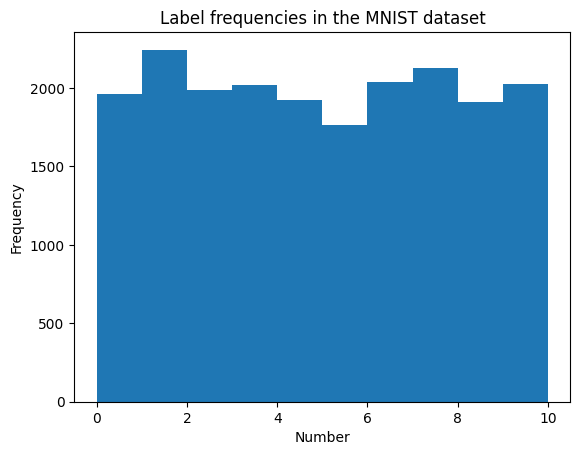

In [41]:
# A Histrogram of the label frequencies
plt.hist(labels, bins=range(11))
plt.xlabel('Number')
plt.ylabel('Frequency')
plt.title('Label frequencies in the MNIST dataset')
plt.show()

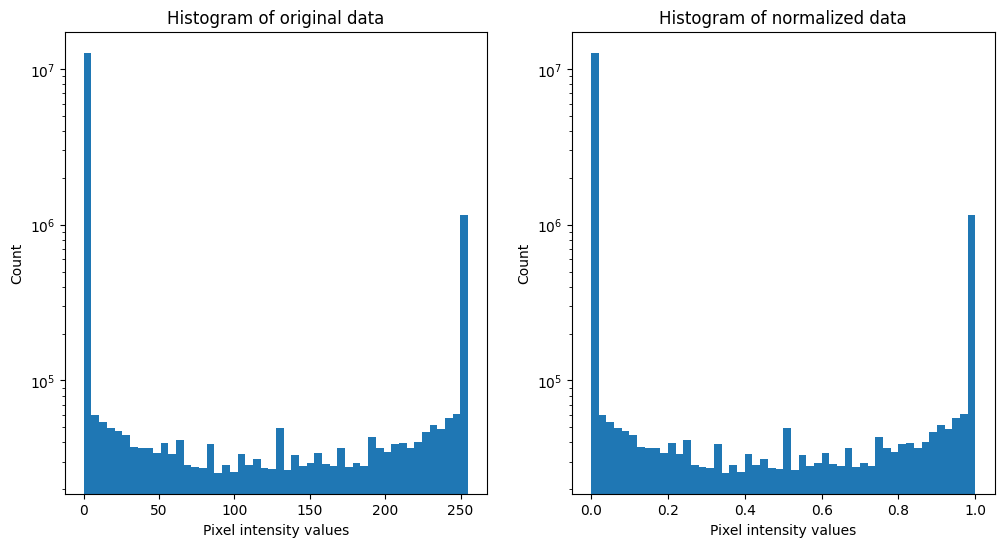

In [42]:
# normalize the data to a range of [0 1]  (just data, not labels)
dataNorm = data / np.max(data)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].hist(data.flatten(), bins=50)
ax[0].set_xlabel('Pixel intensity values')
ax[0].set_ylabel('Count')
ax[0].set_title('Histogram of original data')

ax[1].hist(dataNorm.flatten(), 50)
ax[1].set_xlabel('Pixel intensity values')
ax[1].set_ylabel('Count')
ax[1].set_title('Histogram of normalized data')

# set a log scale for y
ax[0].set_yscale('log')
ax[1].set_yscale('log')

plt.show()

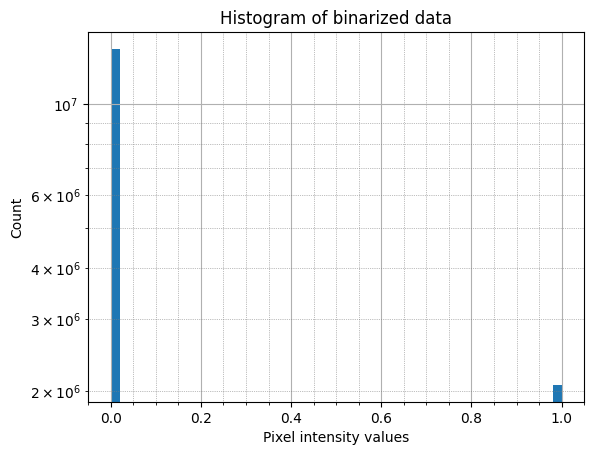

In [43]:
# binarize the data
dataNorm[dataNorm > .5] = 1
dataNorm[dataNorm <= .5] = 0

# show the histogram
plt.hist(dataNorm.flatten(), 50)
plt.xlabel('Pixel intensity values')
plt.ylabel('Count')
plt.title('Histogram of binarized data')
plt.yscale('log')
plt.grid(True)
# draw minor grid lines
plt.minorticks_on()
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
plt.show()


# Create train/test groups using DataLoader

In [44]:
# Step 1: convert to tensor
dataT = torch.tensor(dataNorm)
dataT  # type of each item is still float64

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], dtype=torch.float64)

In [45]:
dataT = dataT.float()  # convert to float32
labelsT = torch.tensor(labels).long()  # long = int64

# Step 2: use scikitlearn to split the data
train_data, test_data, train_labels, test_labels = train_test_split(dataT, labelsT, test_size=.1)

# Step 3: convert into PyTorch Datasets
# -----------------------------------------------------------------------------------------------------
#  A PyTorch dataset is a container for your data. Datasets can be created from many different types of
#  data, including numpy arrays, pandas dataframes, and image folders. The dataset class is an abstract
#  class that you can subclass to create your own dataset. The only requirement is that the subclass
#  implements the __len__ and __getitem__ methods.
# -----------------------------------------------------------------------------------------------------
train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

# Step 4: translate into dataloader objects
# -----------------------------------------------------------------------------------------------------
#  dataloaders are iterable objects that yield batches of data. They can be iterated over in a for loop
#  or while loop, and they return one batch of data (and labels) at each iteration.
#  The DataLoader class also handles shuffling and batching of the data. The parameter drop_last=True 
#  means that if the dataset size is not divisible by the batch size, the last batch will be dropped. 
#  This is important because the last batch is often smaller than the other batches, and training with
#  a smaller batch can lead to unstable training.
# -----------------------------------------------------------------------------------------------------
batchsize = 32
train_loader = DataLoader(train_data, batch_size=batchsize, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

# Create the DL model

In [46]:
# create a class for the model
#   nn.Module is the base class for all models in PyTorch
#   Your models should also subclass this class.  
#   Modules can also contain other Modules, allowing to nest them in a tree structure. 
#   You can assign the submodules as regular attributes, they will be registered, and will be visible to the net.parameters() method.
#   Attributes:
#   training – Boolean represents whether this module is in training or evaluation mode.
def createTheMNISTNet():
    
    class mnistNet(nn.Module):
        def __init__(self):
            super().__init__()

            ### input layer
            self.input = nn.Linear(784, 64)

            ### hidden layer
            self.fc1 = nn.Linear(64, 32)
            self.fc2 = nn.Linear(32, 32)

            ### output layer
            self.output = nn.Linear(32, 10)


        # forward pass
        def forward(self, x):
            x = F.relu(self.input(x))
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            return torch.log_softmax(self.output(x), axis=1)
            # NEW HERE: log-softmax the output, because I'm using NLLLoss instead of CrossEntropyLoss

    # create the model instance
    net_model = mnistNet()

    # loss function
    lossfun = nn.NLLLoss()

    # optimizer (try using Adam instead of SGD ==> it will converge faster and more accurately)
    optimizer = torch.optim.Adam(net_model.parameters(), lr=.01)

    return net_model, lossfun, optimizer

In [47]:
# test the model with one batch
net, lossfun, optimizer = createTheMNISTNet()

X, y = next(iter(train_loader))
yHat = net(X)

# values are log-probability of each number (0-9)
# print(torch.exp(yHat))

# now let's compute the loss
loss = lossfun(yHat, y)

print('\nLoss:', loss.item())
print(loss)


Loss: 2.2988386154174805
tensor(2.2988, grad_fn=<NllLossBackward0>)


# Create a function that trains the model

In [48]:
# a function that trains the model

def trainTheModel():
    # number of epochs
    numepochs = 60

    # create a new model
    net, lossfun, optimizer = createTheMNISTNet()

    # initialize losses
    losses = torch.zeros(numepochs)
    trainAcc = []
    testAcc = []

    # loop over epochs
    for epochi in range(numepochs):

        # loop over training data batches
        batchAcc = []
        batchLoss = []
        for X, y in train_loader:
            # forward pass and loss
            yHat = net(X)
            loss = lossfun(yHat, y)

            # backprop
            optimizer.zero_grad()  # set gradients to zero
            loss.backward()  # compute gradients
            optimizer.step()  # update weights

            # loss from this batch
            batchLoss.append(loss.item())

            # compute accuracy
            matches = torch.argmax(yHat, axis=1) == y  # booleans (false/true)
            matchesNumeric = matches.float()  # convert to numbers (0/1)
            accuracyPct = 100 * torch.mean(matchesNumeric)  # average and x100
            batchAcc.append(accuracyPct)  # add to list of accuracies
        # end of batch loop...

        # now that we've trained through the batches, get their average training accuracy
        trainAcc.append(np.mean(batchAcc))  # append the average accuracy for this epoch

        # and get average losses across the batches
        losses[epochi] = np.mean(batchLoss)  # append the average loss for this epoch

        # test accuracy
        X, y = next(iter(test_loader))  # extract X,y from test dataloader
        yHat = net(X)

        # compare the following really long line of code to the training accuracy lines
        # (see "compute accuracy" above)
        testAcc.append(100 * torch.mean((torch.argmax(yHat, axis=1) == y).float()))

    # end epochs

    # function output
    return trainAcc, testAcc, losses, net


# Run the model and show the results!

In [49]:
trainAcc, testAcc, losses, net = trainTheModel()


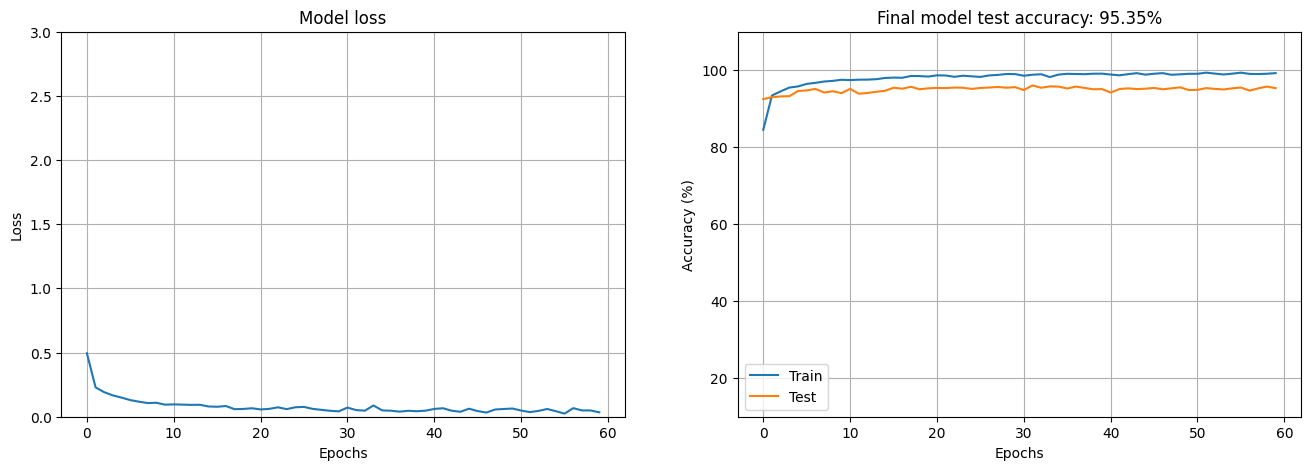

In [50]:
_, ax = plt.subplots(1, 2, figsize=(16, 5))

ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_ylim([0, 3])
ax[0].set_title('Model loss')
ax[0].grid(True)

ax[1].plot(trainAcc, label='Train')
ax[1].plot(testAcc, label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_ylim([10, 110])
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
# draw the grid
ax[1].grid(True)
ax[1].legend()

plt.show()

# Inspect the results in more detail

In [51]:
# run the model through for the test data
X, y = next(iter(test_loader))
predictions = net(X).detach()  # the detach method gets the tensor out of the computation graph (no backprop on this)

print(predictions[0].tolist())  # these are log-probabilities, not probabilities

# back to probabilities
print("\nBack to probabilities: \n", torch.exp(predictions[0]).tolist())
print()
for lab, pred in enumerate(predictions[0]):
    print(f'Number {lab} has probability {torch.exp(pred).item():.6f}')
      

[-60.256202697753906, -26.385272979736328, -115.39784240722656, -505.1347351074219, -38.562950134277344, -35.30623245239258, 0.0, -937.762451171875, -46.557472229003906, -349.1473693847656]

Back to probabilities: 
 [6.777408333684926e-27, 3.475534096630817e-12, 0.0, 0.0, 1.7878190414437284e-17, 4.641924251224002e-16, 1.0, 0.0, 6.030408390627262e-21, 0.0]

Number 0 has probability 0.000000
Number 1 has probability 0.000000
Number 2 has probability 0.000000
Number 3 has probability 0.000000
Number 4 has probability 0.000000
Number 5 has probability 0.000000
Number 6 has probability 1.000000
Number 7 has probability 0.000000
Number 8 has probability 0.000000
Number 9 has probability 0.000000


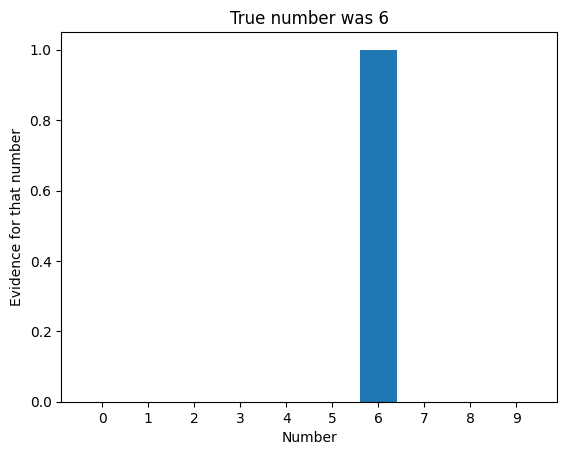

In [52]:
# Evidence for all numbers from one sample
sample2show = 0

plt.bar(range(10), np.exp(predictions[sample2show]))  # try adding exp!
plt.xticks(range(10))
plt.xlabel('Number')
plt.ylabel('Evidence for that number')
plt.title('True number was %s' % y[sample2show].item())
# set log scale for y
# plt.yscale('log')
plt.show()

errors: [  35   39   51   54  102  135  136  167  170  210  218  227  240  257
  269  282  330  375  447  512  520  544  591  656  661  675  703  706
  718  724  745  749  765  786  800  821  840  846  883  904  907  919
  921 1046 1065 1087 1090 1138 1139 1142 1176 1188 1218 1240 1248 1252
 1254 1256 1275 1276 1278 1369 1420 1467 1507 1518 1522 1524 1549 1578
 1587 1590 1642 1646 1658 1673 1702 1738 1741 1788 1790 1830 1858 1868
 1886 1896 1912 1922 1925 1928 1939 1964 1996]


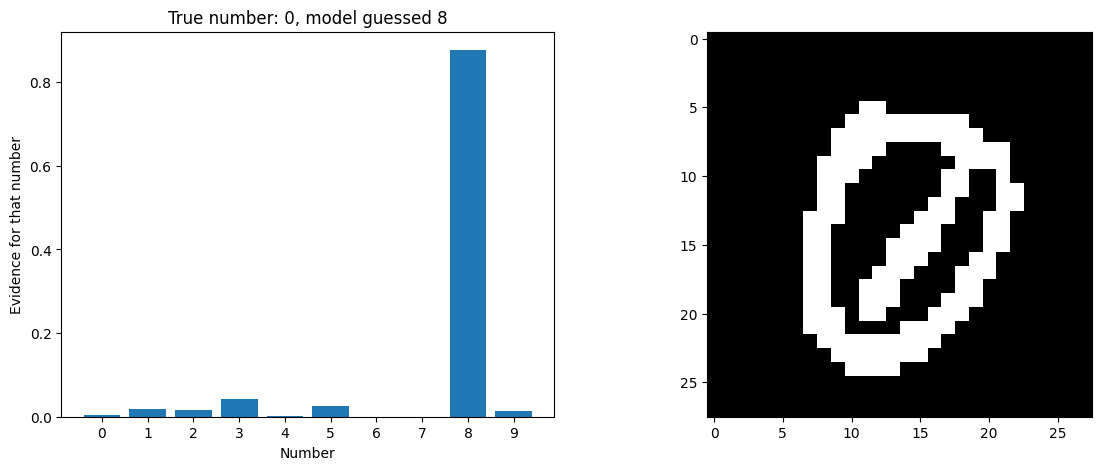

In [53]:
# find the errors
errors = np.where(torch.max(predictions, axis=1)[1] != y)[0]
print(f'errors: {errors}')

# Evidence for all numbers from one sample
sample2show = 80

fig, ax = plt.subplots(1, 2, figsize=(14, 5))

ax[0].bar(range(10), np.exp(predictions[errors[sample2show]]))
ax[0].set_xticks(range(10))
ax[0].set_xlabel('Number')
ax[0].set_ylabel('Evidence for that number')
ax[0].set_title('True number: %s, model guessed %s'
                % (y[errors[sample2show]].item(), torch.argmax(predictions[errors[sample2show]]).item()))

ax[1].imshow(np.reshape(X[errors[sample2show], :], (28, 28)), cmap='gray')

plt.show()

# Additional explorations

In [54]:
# 1) Average together the correct 7's and the error 7's, and make images of them (that is, one image
#    of all correct 7's and one image of all incorrectly labeled 7's). How do they look?
# 
# 2) Repeat #1 for all numbers to produce a 2x10 matrix of images with corrects on top
#    and errors on the bottom.
# 
# 3) Identify "almost errors," which we can define as correct categorizations that had a probability of
#    e.g., >.1 for any other number. Make images of some of these numbers. Can you understand why the model
#    was confused?
# 
# 4) I didn't use .train(), .eval(), or no_grad() here. Is that a problem? Can you add those in without checking
#    other notebooks?
# 